In [1]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# ResNet50

example image

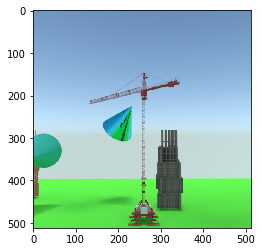

In [2]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [3]:
input_shape = img.shape

In [4]:
img = img.reshape((1,512,512,3))
img.shape

(1, 512, 512, 3)

In [5]:
img = tf.cast(img, dtype=tf.float32)

In [6]:
class_num = 1

In [7]:
input_tensor = layers.Input(input_shape)

load ResNet50

In [8]:
base_model = applications.ResNet50(include_top=False, input_shape=input_shape, weights=None, pooling='avg')
    
x = base_model.output
x = layers.Dense(1000, activation="softmax")(x)
resnet50 = Model(base_model.input, x)

#freeze layer
for layer in resnet50.layers:
    layer.trainable = False

#load pre_trained weight
resnet50.load_weights("resnet50_ImageNet.h5")

#unfreeze layer
for layer in resnet50.layers[:174]:
    layer.trainable = True

In [9]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

extract feature C1~C5

In [10]:
C1 = resnet50.get_layer('pool1_pad').output
C2 = resnet50.get_layer('conv2_block3_out').output
C3 = resnet50.get_layer('conv3_block4_out').output
C4 = resnet50.get_layer('conv4_block6_out').output
C5 = resnet50.get_layer('conv5_block3_out').output

# Feature Pyramid Network

In [11]:
def P5(x, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

def FPN(x, y, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    y = layers.UpSampling2D()(y)
    
    P = layers.Add()([x, y])
    
    return P

In [12]:
P5 = P5(C5)
P4 = FPN(C4, P5)
P3 = FPN(C3, P4)
P2 = FPN(C2, P3)

In [13]:
def FM(x, upsampling, train_bn=True):
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    if upsampling != 1:
        x = layers.Conv2DTranspose(128, (3, 3), strides=(upsampling, upsampling), padding='same')(x)
        x = layers.BatchNormalization()(x, training=train_bn)
        x = layers.Activation('relu')(x)
    
    return x

feature map

In [14]:
FM5 = FM(P5, 8)
FM4 = FM(P4, 4)
FM3 = FM(P3, 2)
FM2 = FM(P2, 1)
FM = layers.concatenate([FM5, FM4, FM3, FM2])
FM.shape

TensorShape([None, 128, 128, 512])

head

In [15]:
def Head(x, train_bn=True):
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

In [16]:
H = Head(FM)
H.shape

TensorShape([None, 128, 128, 512])

resize feature map

In [17]:
def Resize(x, train_bn=True):
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(class_num, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('sigmoid')(x)
    
    return x

In [18]:
output = Resize(H)
output.shape

TensorShape([None, 512, 512, 1])

make model

In [19]:
NADS_Net = Model(resnet50.input, output)
NADS_Net = utils.multi_gpu_model(NADS_Net, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [20]:
NADS_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 1)  36242693    lambda[0][0]                     
                                                                 lambda_1[0][0]             

In [21]:
example = NADS_Net(img)
example.shape

TensorShape([1, 512, 512, 1])

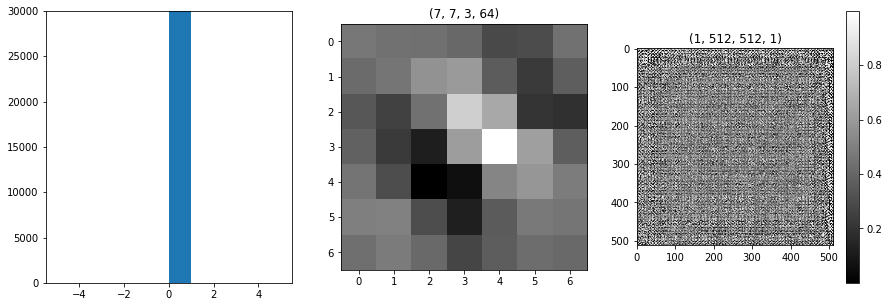

In [22]:
weight = NADS_Net.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 30000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [23]:
HEIGHT = 512
WIDTH = 512

train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')

In [24]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_semantic/%s.png'%label_name
    label = plt.imread(label_path)
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [25]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [26]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [27]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0)]
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

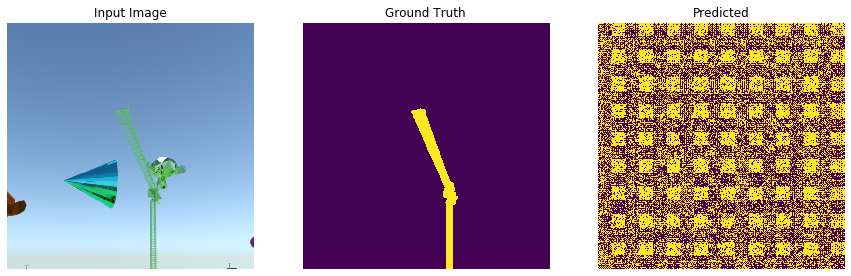

In [28]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(NADS_Net, image, label)

# Define Loss and Optimizer

In [29]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [30]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [31]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, NADS_Net=NADS_Net)

# Train

In [32]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 100
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [33]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [ ]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(NADS_Net, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(NADS_Net, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    #train_accuracy.reset_states()
    #train_recall.reset_states()
    val_loss.reset_states()
    #val_accuracy.reset_states()
    #val_recall.reset_states()
    
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

# Loss Curve

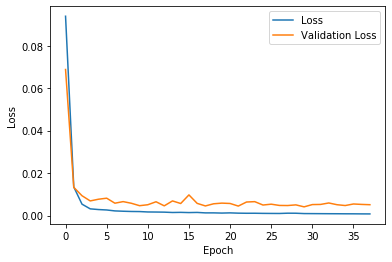

In [35]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [42]:
checkpoint.restore('C:/Users/IVCL/Desktop/NADS_Net/checkpoints/ckpt-1')

# Test

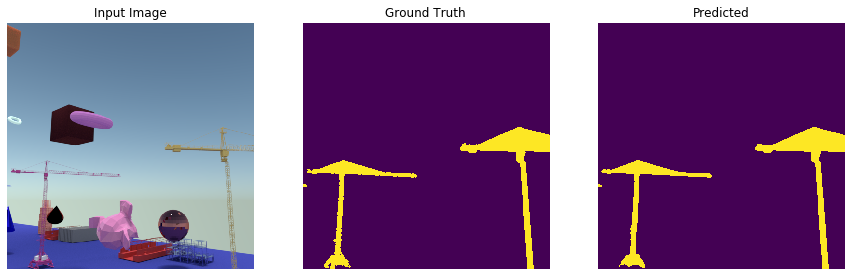

In [76]:
num = 900
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(NADS_Net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


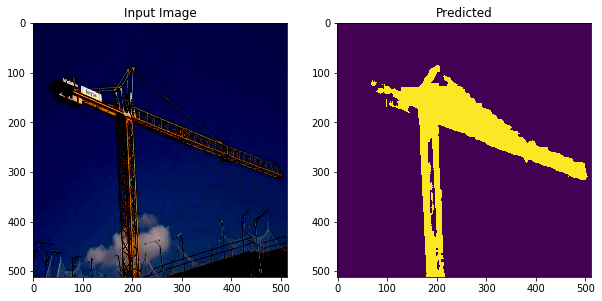

In [88]:
image = read_image('C:/Users/IVCL/Desktop/TC_Real_512/0288.jpg')
image = image[tf.newaxis, ...]
prediction = NADS_Net(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()